# Sci-Plex 2 Training notebook

In [ ]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [1]:
from sklearn.metrics import r2_score
import numpy as np

import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import cpa
import scanpy as sc

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=100)

In [4]:
data_path = '/home/mohsen/projects/cpa/datasets/GSM_new.h5ad'

In [5]:
adata = sc.read(data_path)
adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
cpa.CPA.setup_anndata(adata, 
                      drug_key='condition',
                      dose_key='dose_val',
                      categorical_covariate_keys=['cell_type'],
                      control_key='control',
                     )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 14811 cells, 4999 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [7]:
ae_hparams = {'autoencoder_depth': 4,
              'autoencoder_width': 512,
              'adversary_depth': 3,
              'adversary_width': 256,
              'dosers_depth': 3,
              'dosers_width': 64,
              'use_batch_norm': True,
              'use_layer_norm': False,
              'output_activation': 'linear',
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 60,
              }

trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 0.0006158304832265454,
    'adversary_wd': 3.546249921082396e-06,
    'adversary_steps': 5,
    'autoencoder_lr': 0.002563090275772759,
    'autoencoder_wd': 2.8299682410882683e-05,
    'dosers_lr': 0.0028643381083830787,
    'dosers_wd': 7.850495446598981e-07,
    'penalty_adversary': 6.20968938643343,
    'reg_adversary': 1.323092865499999,
    'kl_weight': 0.00000,
    'step_size_lr': 45,
}

In [8]:
model = cpa.CPA(adata=adata, 
                n_latent=256,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Global seed set to 60


In [9]:
model.train(max_epochs=1500,
            use_gpu=True, 
            batch_size=64,
            early_stopping=True,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=20,
            save_path='/home/mohsen/projects/cpa/lightning_logs/GSM_new/',
           )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name   | Type      | Params
-------------------------------------
0 | module | CPAModule | 9.7 M 
-------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.911    Total estimated model params size (MB)


Epoch 20/1500:   1%|▉                                                                 | 20/1500 [02:11<2:40:24,  6.50s/it, recon=-.243, adv_acc=0.299]

/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/scvi/train/_callbacks.py:93: RuntimeWarning: Can save best module state only with cpa_metric available, skipping.
  warnings.warn(


Epoch 39/1500:   3%|   | 39/1500 [04:32<2:43:08,  6.70s/it, recon=-.263, adv_acc=0.274, val_recon=-1.27, val_disnt_basal=0.343, val_disnt_after=0.644]


Epoch 00038: cpa_metric reached. Module best state updated.


Epoch 58/1500:   4%|▏   | 58/1500 [06:46<2:38:01,  6.58s/it, recon=-.269, adv_acc=0.27, val_recon=-1.36, val_disnt_basal=0.315, val_disnt_after=0.592]


Epoch 00057: cpa_metric reached. Module best state updated.


Epoch 210/1500:  14%|▏| 210/1500 [24:39<2:30:28,  7.00s/it, recon=-.283, adv_acc=0.271, val_recon=-1.43, val_disnt_basal=0.361, val_disnt_after=0.668]


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 305/1500:  20%|▍ | 305/1500 [35:18<2:34:56,  7.78s/it, recon=-.283, adv_acc=0.264, val_recon=-1.42, val_disnt_basal=0.34, val_disnt_after=0.759]


Epoch 00304: cpa_metric reached. Module best state updated.


Epoch 320/1500:  21%|▍ | 320/1500 [37:14<2:13:36,  6.79s/it, recon=-.281, adv_acc=0.285, val_recon=-1.42, val_disnt_basal=0.34, val_disnt_after=0.759]

/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 362/1500:  24%|▍ | 362/1500 [42:28<2:46:20,  8.77s/it, recon=-.295, adv_acc=0.271, val_recon=-1.4, val_disnt_basal=0.261, val_disnt_after=0.758]


Epoch 00361: cpa_metric reached. Module best state updated.


Epoch 400/1500:  27%|▎| 400/1500 [46:36<1:46:38,  5.82s/it, recon=-.285, adv_acc=0.272, val_recon=-1.41, val_disnt_basal=0.342, val_disnt_after=0.663]


Epoch 00399: cpa_metric reached. Module best state updated.


Epoch 553/1500:  37%|▎| 553/1500 [1:04:28<1:40:46,  6.38s/it, recon=-.288, adv_acc=0.27, val_recon=-1.43, val_disnt_basal=0.254, val_disnt_after=0.887


Epoch 00552: cpa_metric reached. Module best state updated.


Epoch 610/1500:  41%|▊ | 610/1500 [1:10:34<1:27:16,  5.88s/it, recon=-.29, adv_acc=0.269, val_recon=-1.43, val_disnt_basal=0.3, val_disnt_after=0.942]


Epoch 00609: cpa_metric reached. Module best state updated.


Epoch 900/1500:  60%|▌| 900/1500 [1:45:08<1:10:05,  7.01s/it, recon=-.291, adv_acc=0.271, val_recon=-1.34, val_disnt_basal=0.413, val_disnt_after=0.83


In [10]:
test_dataset = adata[adata.obs['split'] == 'test']

In [11]:
latent_basal_adata, latent_adata = model.get_latent_representation(test_dataset, batch_size=1024)

INFO     Received view of anndata, making copy.                                              


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [12]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


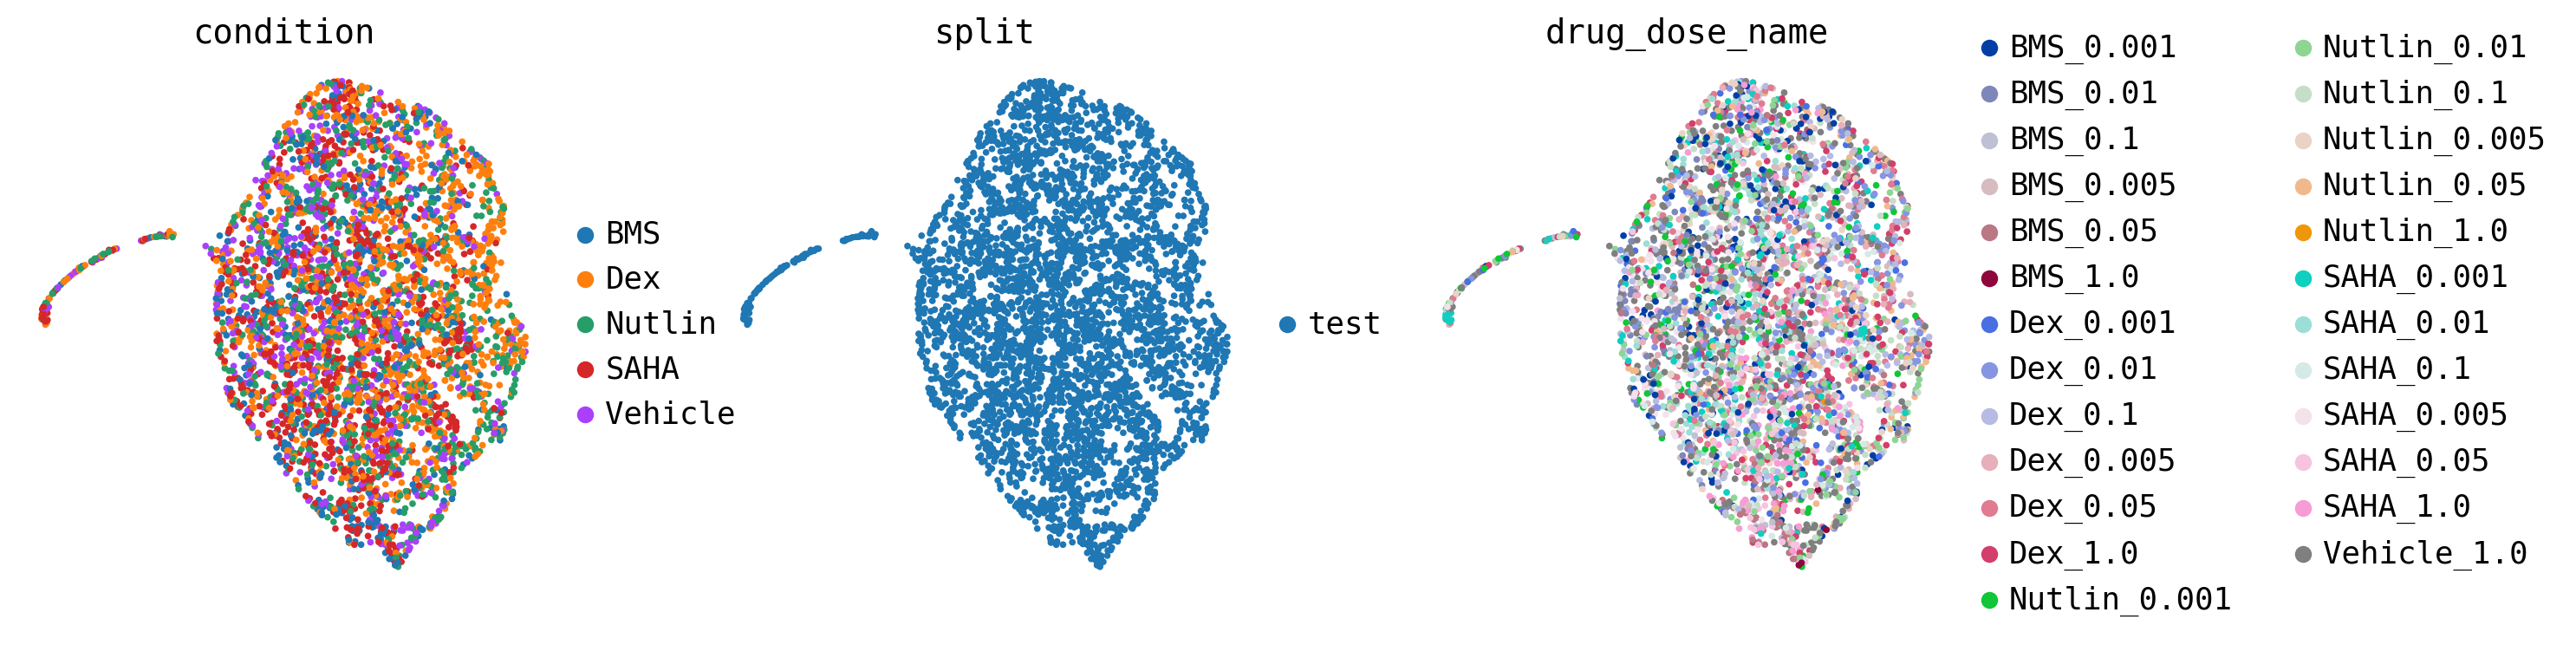

In [13]:
sc.pl.umap(latent_basal_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [14]:
import torch
inference_outputs = tensors = {}
inference_outputs['latent_basal'] = torch.Tensor(latent_basal_adata.X).to(model.device)
inference_outputs['latent'] = torch.Tensor(latent_adata.X).to(model.device)
tensors['drug_name'] = torch.Tensor(test_dataset.obs['condition_scvi'].values).to(model.device)

In [15]:
model.module.disentanglement(tensors, inference_outputs, None)

(0.26955166175030465, 0.914501877264631)

In [16]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


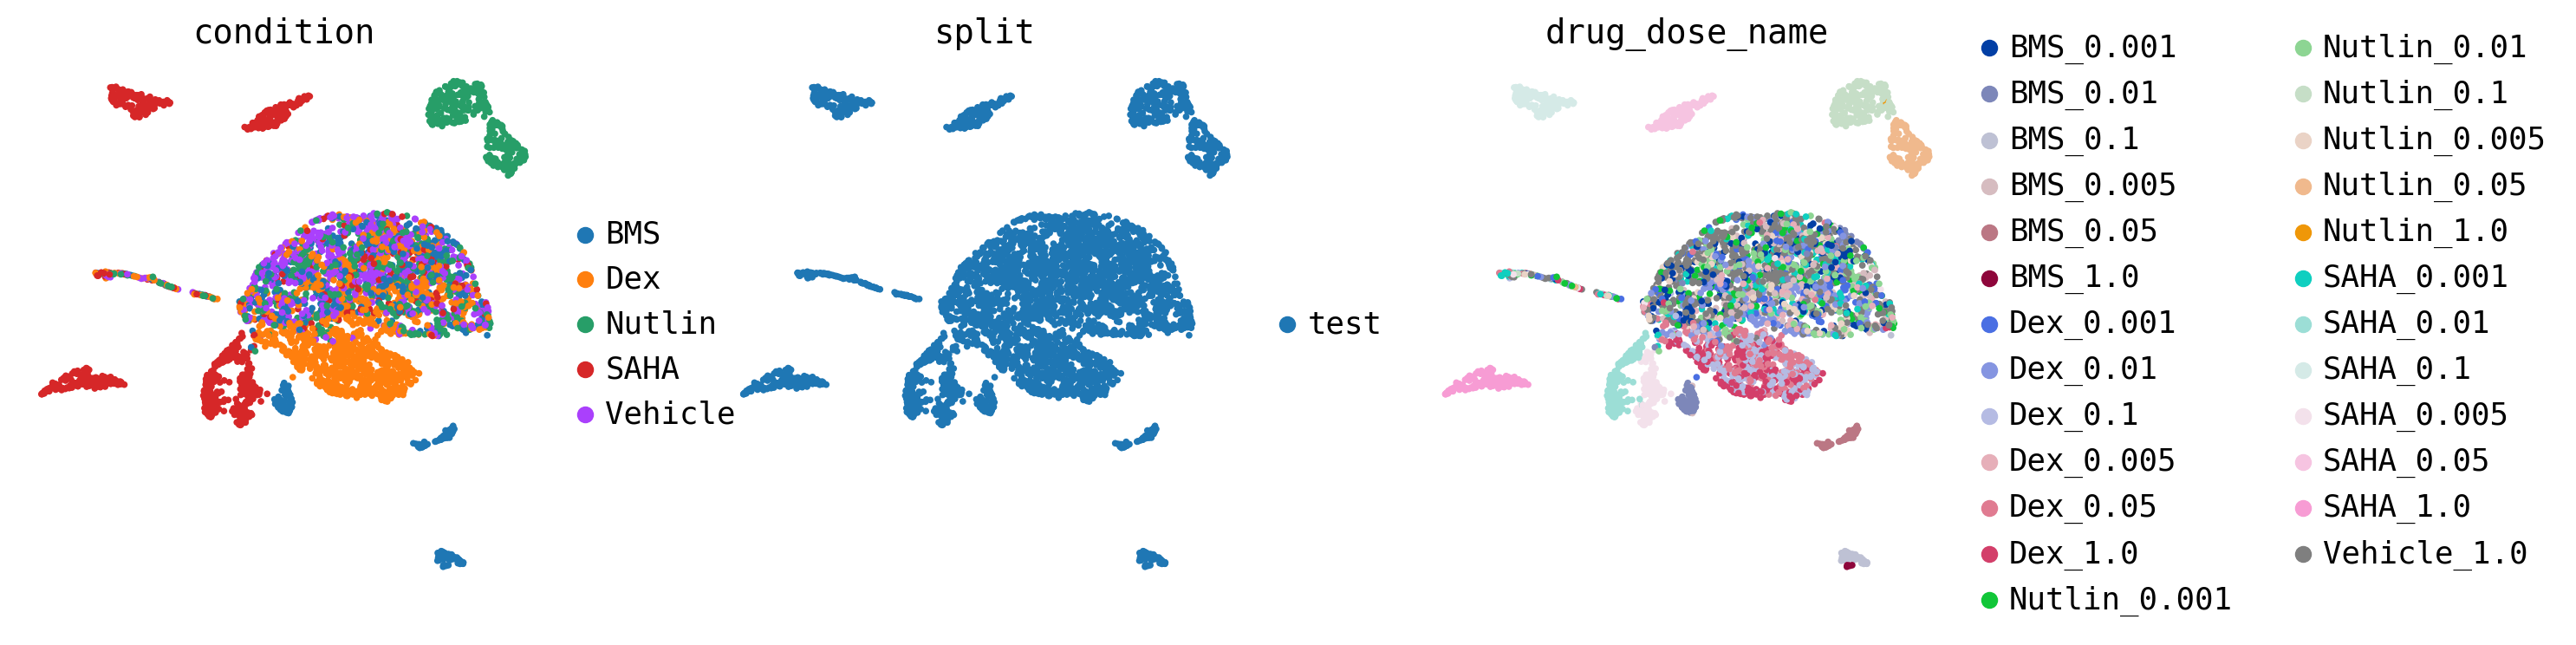

In [17]:
sc.pl.umap(latent_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [18]:
pred_adata_mean, pred_adata_var = model.predict(test_dataset, batch_size=128)

INFO     Received view of anndata, making copy.                                              


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [19]:
r2_score(test_dataset.X.A.mean(0), pred_adata_mean.X.mean(0))

0.990724328611263

In [20]:
r2_score(np.ravel(test_dataset.X.A.var(0)), pred_adata_var.X.mean(0))

0.9181460075100121

All genes var:  0.990724328611263


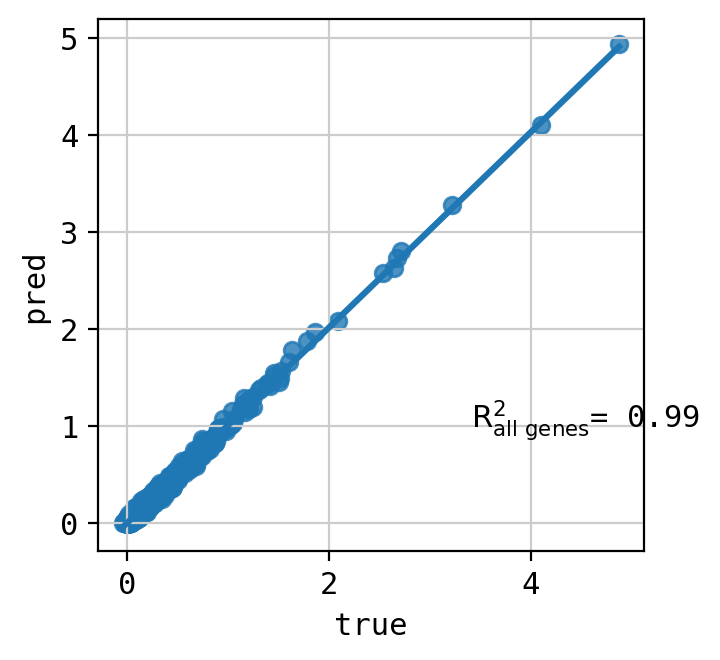

0.990724328611263

In [21]:
cpa.pl.mean_plot(test_dataset, pred_adata_mean, None, None, None, show=True, verbose=True)

In [35]:
pred_adata_mean.var_names = test_dataset.var_names

In [36]:
test_dataset.obs['type'] = 'real_test'
pred_adata_mean.obs['type'] = 'pred_test'
pred_real_adata = test_dataset.concatenate(pred_adata_mean)

In [37]:
sc.pp.neighbors(pred_real_adata)
sc.tl.umap(pred_real_adata)

/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'type' as categorical


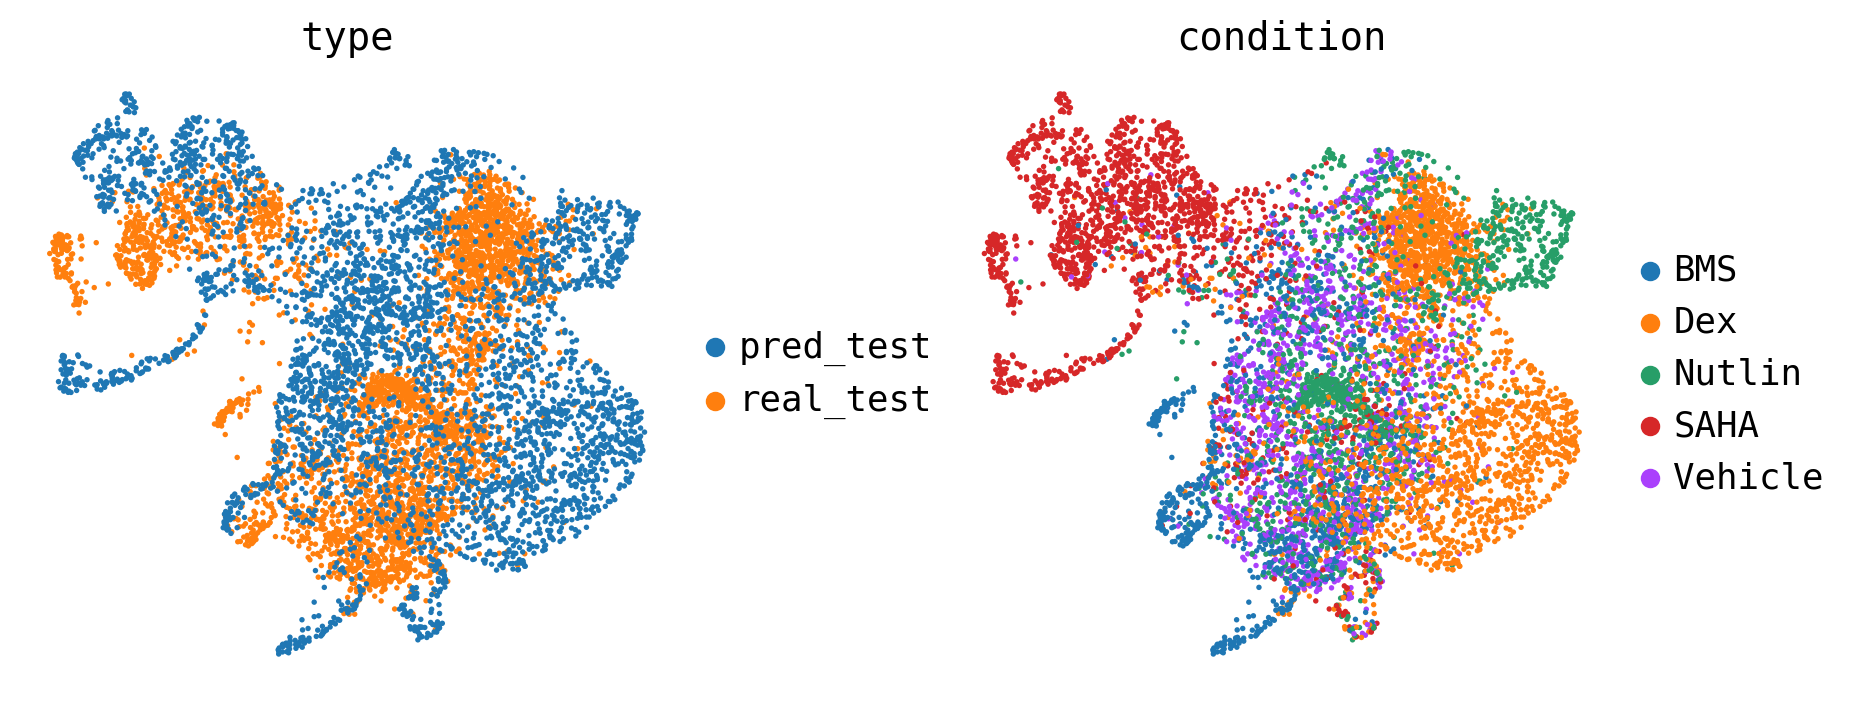

In [38]:
sc.pl.umap(pred_real_adata, color=['type', 'condition'], wspace=0.3, frameon=False)

In [39]:
train_dataset = adata[adata.obs['split'] == 'train']

In [40]:
pred_adata_mean, pred_adata_var = model.predict(train_dataset, batch_size=128)

INFO     Received view of anndata, making copy.                                              


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [41]:
r2_score(train_dataset.X.A.mean(0), pred_adata_mean.X.mean(0))

0.9913038355419667

In [42]:
r2_score(train_dataset.X.A.var(0), pred_adata_var.X.mean(0))

0.9297362090560387